In [ ]:
!python -m venv venv && source venv/bin/activate
!pip install --upgrade pip
!pip install numpy pandas matplotlib scikit-learn tensorflow datasets transformers torch sentencepiece
# If space/time is limited: skip transformers & datasets until Task 3

Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
from tensorflow.keras.datasets import imdb
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words=20000)
# Convert integer sequences to text (simple) or use as sequences for Keras model.

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Dataset exploration

In [ ]:
from datasets import load_dataset
raw = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
import numpy as np

texts = np.concatenate((x_train, x_test))
labels = np.concatenate((y_train, y_test))

df = pd.DataFrame({'text': texts, 'label': labels})
print(df['label'].value_counts())

label
1    25000
0    25000
Name: count, dtype: int64


Bar char

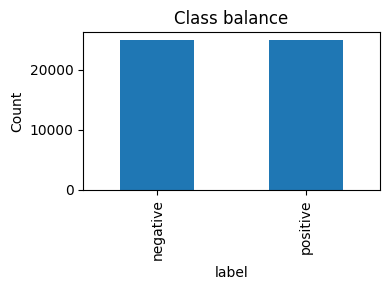

In [ ]:
import matplotlib.pyplot as plt
counts = df['label'].value_counts().sort_index()
plt.figure(figsize=(4,3))
counts.plot(kind='bar')
plt.xticks([0,1], ['negative','positive'])
plt.ylabel('Count'); plt.title('Class balance'); plt.tight_layout(); plt.show()


Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.datasets import imdb # Ensure imdb is imported for get_word_index()

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Retrieve the word index and create a reverse mapping
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Function to decode the integer sequences back to text
def decode_review(text_sequence):
    # IMDb indices are offset by 3 for padding, start of sequence, and unknown tokens.
    # Some reviews might have words outside the num_words limit, so use '?' for unknown.
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text_sequence])

# Convert the integer sequences in X_train and X_test to text strings
X_train_text = X_train.apply(decode_review)
X_test_text = X_test.apply(decode_review)

vect = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)
Xtr = vect.fit_transform(X_train_text) # Use the text converted data
Xte = vect.transform(X_test_text)     # Use the text converted data

clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, y_train)
yp = clf.predict(Xte)
print('Logistic Regression:')
print(classification_report(y_test, yp, digits=4))
print('Accuracy:', accuracy_score(y_test, yp))

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Logistic Regression:
              precision    recall  f1-score   support

           0     0.9078    0.8880    0.8978      5000
           1     0.8904    0.9098    0.9000      5000

    accuracy                         0.8989     10000
   macro avg     0.8991    0.8989    0.8989     10000
weighted avg     0.8991    0.8989    0.8989     10000

Accuracy: 0.8989


Bi-LSTM (Keras)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

num_words = 20000
maxlen = 150   # shorter for speed
tok = Tokenizer(num_words=num_words, oov_token='<OOV>')

# Convert integer sequences in df['text'] to actual text strings
df_text_decoded = df['text'].apply(decode_review)

tok.fit_on_texts(df_text_decoded)
seqs = tok.texts_to_sequences(df_text_decoded)
seqs = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(seqs, df['label'].values, test_size=0.2, random_state=42, stratify=df['label'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

vocab_size = num_words
embed_dim = 128
rnn_units = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=maxlen),
    Bidirectional(LSTM(rnn_units)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=3, batch_size=128)
pred = (model.predict(X_test) > 0.5).astype(int).reshape(-1)
from sklearn.metrics import classification_report, accuracy_score
print('Bi-LSTM:')
print(classification_report(y_test, pred, digits=4))
print('Accuracy:', accuracy_score(y_test, pred))


Epoch 1/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.6974 - loss: 0.5430 - val_accuracy: 0.8620 - val_loss: 0.3340
Epoch 2/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 277s 981ms/step - accuracy: 0.9014 - loss: 0.2586 - val_accuracy: 0.8595 - val_loss: 0.3203
Epoch 3/3
282/282 ━━━━━━━━━━━━━━━━━━━━ 277s 983ms/step - accuracy: 0.9304 - loss: 0.1921 - val_accuracy: 0.8618 - val_loss: 0.3585
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step
Bi-LSTM:
              precision    recall  f1-score   support

           0     0.8680    0.8498    0.8588      5000
           1     0.8529    0.8708    0.8618      5000

    accuracy                         0.8603     10000
   macro avg     0.8605    0.8603    0.8603     10000
weighted avg     0.8605    0.8603    0.8603     10000

Accuracy: 0.8603
